# Creating a LlamaIndex RAG Pipeline with NL2SQL and Metadata Filtering!

We'll be putting together a system for querying both qualitative and quantitative data using LlamaIndex.

The acitvities will be broken down as follows:

- 🤝 Breakout Room #1
  - Task 1: Load Dependencies
  - Task 2: Set Env Variables and Set Up WandB Callback
  - Task 3: Initialize Settings
  - Task 4: Index Creation
  - Task 5: Simple RAG - `QueryEngine`
  - Task 6: Auto Rertriever Functional Tool
- 🤝 Breakout Room #2
  - Task 1: Quantitative RAG Pipeline with NL2SQL Tooling
  - Task 2: Combined RAG Pipeline

Before we get started, however, a quick note on terminology.

# 🤝 Breakout Room #1

## BOILERPLATE

This is only relevant when running the code in a Jupyter Notebook.

In [56]:
import nest_asyncio

nest_asyncio.apply()

import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

## Load Dependencies

Let's grab our core `llama-index` library, as well as OpenAI's Python SDK.

We'll be leveraging OpenAI's suite of APIs to power our RAG pipelines today.

> NOTE: You can safely ignore any pip errors that occur during the running of these cells.

In [57]:
!pip install -qU llama-index openai anthropic

8310.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


We'll be collecting our semantic data from Wikipedia - and so will need the [Wikipedia Reader](https://github.com/run-llama/llama_index/tree/main/llama-index-integrations/readers/llama-index-readers-wikipedia)!

In [58]:
!pip install -qU wikipedia llama-index-readers-wikipedia

8323.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Our vector database today will be powered by [QDrant](https://qdrant.tech/) and so we'll need that package as well!

In [59]:
!pip install -qU llama-index-vector-stores-qdrant qdrant-client

8332.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Finally, we'll need to grab a few dependencies related to our quantitative data!

In [60]:
!pip install -q -U sqlalchemy pandas

8341.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


We'll can use [Weights and Biases](https://docs.wandb.ai/guides/prompts) (WandB) as a visibility platform, as well as storing our index!

In [61]:
!pip install -qU wandb llama-index-callbacks-wandb

8360.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [62]:
import os
import getpass

os.environ["WANDB_API_KEY"] = getpass.getpass("WandB API Key: ")

os.environ['WANDB_NOTEBOOK_NAME'] = 'Building_Advanced_RAG_with_LlamaIndex_Assignment_Version.ipynb'

We'll also need to set a callback handler for WandB to ensure smooth operation of our traces!

In [63]:
import llama_index
from llama_index.core import set_global_handler

set_global_handler("wandb", run_args={"project": "llama-index-rag-v1"})
wandb_callback = llama_index.core.global_handler

## Task 2: Set Env Variables and Set Up WandB Callback

Let's set our API keys for both OpenAI and WandB!

In [64]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

### OPTIONAL ADVANCED PATH:

Instead of OpenAI - you could use Anthropic's new Claude model `Sonnet 3.5`!

Let's see how the flow might be different if you wanted to use the latest and greatest from Anthropic!

> NOTE: You will need an [API Key](https://www.anthropic.com/news/claude-3-5-sonnet) for `Sonnet 3.5` for the following cells to work!

In [9]:
# OPTIONAL ADVANCED PATH
!pip install -qU llama-index-llms-anthropic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.7/862.7 kB 6.9 MB/s eta 0:00:00


In [17]:
# OPTIONAL ADVANCED PATH
os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Anthropic API Key: ")

Anthropic API Key: ··········


In [18]:
# OPTIONAL ADVANCED PATH
from llama_index.llms.anthropic import Anthropic
from llama_index.core import Settings

Settings.llm = Anthropic(model="claude-3-5-sonnet-20240620")

## Task 3: Settings

LlamaIndex lets us set global settings which we can use to influence the default behaviour of our components.

Let's set our LLM and our Embedding Model!

In [65]:
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings

Settings.llm = OpenAI(model="gpt-4o")

In [66]:
from llama_index.embeddings.openai import OpenAIEmbedding
Settings.embedding = OpenAIEmbedding(model="text-embedding-3-small")

## Task 4: `Index` Creation

In order for us to perform RAG in the traditional sense - we need an `Index`.

So what is an `Index`? Well - let's see how LlamaIndex defines it:

> In LlamaIndex terms, an `Index` is a data structure composed of Document objects, designed to enable querying by an LLM. Your Index is designed to be complementary to your querying strategy.

Okay, so we know that we have a boatload of Wikipedia content - and we know that we want to be able to query the `Index` and receive documents that are related to our query - so let's use an `Index` built on the idea of embedding-vectors.

Introducing: `VectorStoreIndex`!

Again, let's see how LlamaIndex defines this:

> A `VectorStoreIndex` is by far the most frequent type of `Index` you'll encounter. The Vector Store Index takes your Documents and splits them up into Nodes. It then creates `vector` embeddings of the text of every node, ready to be queried by an LLM.

Alright, that sounds awesome - let's make one!

### Data Collection

We're just going to be pulling information straight from Wikipedia using the built in `WikipediaReader`.

> NOTE: Setting `auto_suggest=False` ensures we run into fewer auto-correct based errors.

### A note on terminology:

You'll notice that there are quite a few similarities between LangChain and LlamaIndex. LlamaIndex can largely be thought of as an extension to LangChain, in some ways - but they moved some of the language around. Let's spend a few moments disambiguating the language.

- `QueryEngine` -> `LCEL Chain`:
  -  `QueryEngine` is just LlamaIndex's way of indicating something is an LLM "chain" on top of a retrieval system
- `OpenAIAgent` vs. `Agent`:
  - The two agents have the same fundamental pattern: Decide which of a list of tools to use to answer a user's query.
  - `OpenAIAgent` (LlamaIndex's primary agent) does not need to rely on an agent excecutor due to the fact that it is leveraging OpenAI's [functional api](https://openai.com/blog/function-calling-and-other-api-updates) which allows the agent to interface "directly" with the tools instead of operating through an intermediary application process.

There is, however, a much large terminological difference when it comes to discussing data.

##### Nodes vs. Documents

As you're aware of from the previous weeks assignments, there's an idea of `documents` in NLP which refers to text objects that exist within a corpus of documents.

LlamaIndex takes this a step further and reclassifies `documents` as `nodes`. Confusingly, it refers to the `Source Document` as simply `Documents`.

The `Document` -> `node` structure is, almost exactly, equivalent to the `Source Document` -> `Document` structure found in LangChain - but the new terminology comes with some clarity about different structure-indices.

We won't be leveraging those structured indicies today, but we will be leveraging a "benefit" of the `node` structure that exists as a default in LlamaIndex, which is the ability to quickly filter nodes based on their metadata.

![image](https://i.imgur.com/B1QDjs5.png)

In [67]:
from llama_index.readers.wikipedia import WikipediaReader

movie_list = [
    "Dune (2021 film)",
    "Dune: Part Two",
    "The Lord of the Rings: The Fellowship of the Ring",
    "The Lord of the Rings: The Two Towers",
]

wiki_docs = WikipediaReader().load_data(pages=movie_list, auto_suggest=False)

### Initializing our `VectorStoreIndex` with QDrant

QDrant is a locally hostable and open-source vector database solution.

It offers powerful features like metadata filtering out of the box, and will suit our needs well today!

We'll start by creating our local `:memory:` client (in-memory and not meant for production use-cases) and our collection.

In [68]:
from llama_index.vector_stores.qdrant import QdrantVectorStore
from qdrant_client import QdrantClient, models

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="movie_wikis",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

True

Then we'll create our `VectorStore` and `StorageContext` which will allow us to create an empty `VectorStoreIndex` which we will be able to add nodes to later!

In [69]:
from llama_index.core import VectorStoreIndex
from llama_index.core import StorageContext

vector_store = QdrantVectorStore(client=client, collection_name="movie_wikis")

storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex.from_documents(
    [],
    storage_context=storage_context,
)

wandb: Logged trace tree to W&B.


### Node Construction

Now we will loop through our documents and metadata and construct nodes.

We'll make sure to explicitly associate our nodes with their respective movie so we can filter by the movie title in the upcoming cells.

You might be thinking to yourself - wait, we never indicated which embedding model this should use - but remember

In [70]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core.ingestion import IngestionPipeline
from llama_index.core.node_parser import TokenTextSplitter
from llama_index.core.extractors import TitleExtractor

pipeline = IngestionPipeline(transformations=[TokenTextSplitter()])

for movie, wiki_doc in zip(movie_list, wiki_docs):
  nodes = pipeline.run(documents=[wiki_doc])
  for node in nodes:
      node.metadata = {"title" : movie}
  index.insert_nodes(nodes)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


wandb: Logged trace tree to W&B.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


wandb: Logged trace tree to W&B.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


wandb: Logged trace tree to W&B.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


wandb: Logged trace tree to W&B.


####❓ Question #1:

What `metadata` fields will the nodes in our index have? Title.

> You will need to write code to find this information

In [155]:
for node in nodes:
  print(node.metadata)


{'title': 'Movie 1'}
{'title': 'Movie 1'}
{'title': 'Movie 1'}
{'title': 'Movie 1'}
{'title': 'Movie 1'}
{'title': 'Movie 1'}
{'title': 'Movie 1'}
{'title': 'Movie 1'}
{'title': 'Movie 1'}


### Persisting and Loading Stored Index with Weights and Biases

Now we can utilize a powerful feature of Weights and Biases - index and artifact versioning!

We can persist our index to WandB to be used and loaded later!

In [78]:
wandb_callback.persist_index(index, index_name="movie-index-qdrant")

wandb: Adding directory to artifact (/Users/sampazar/ML-Ops/AIE3/Week 5/Day 1/wandb/run-20240701_133427-kcwp0izl/files/storage)... Done. 0.6s


Now we can load our index from WandB, which is a truly powerful tool!

In [86]:
from llama_index.core import load_index_from_storage

storage_context = wandb_callback.load_storage_context(
    artifact_url="ascend-impact-advisors/llama-index-rag-v1/movie-index-qdrant:v0"
)

wandb:   4 of 4 files downloaded.  


####❓ Question #2:

Provide a screenshot of your index version history as shown in WandB.

You can find your screenshot by doing the following:

![image](https://i.imgur.com/Y0AHkQI.png)

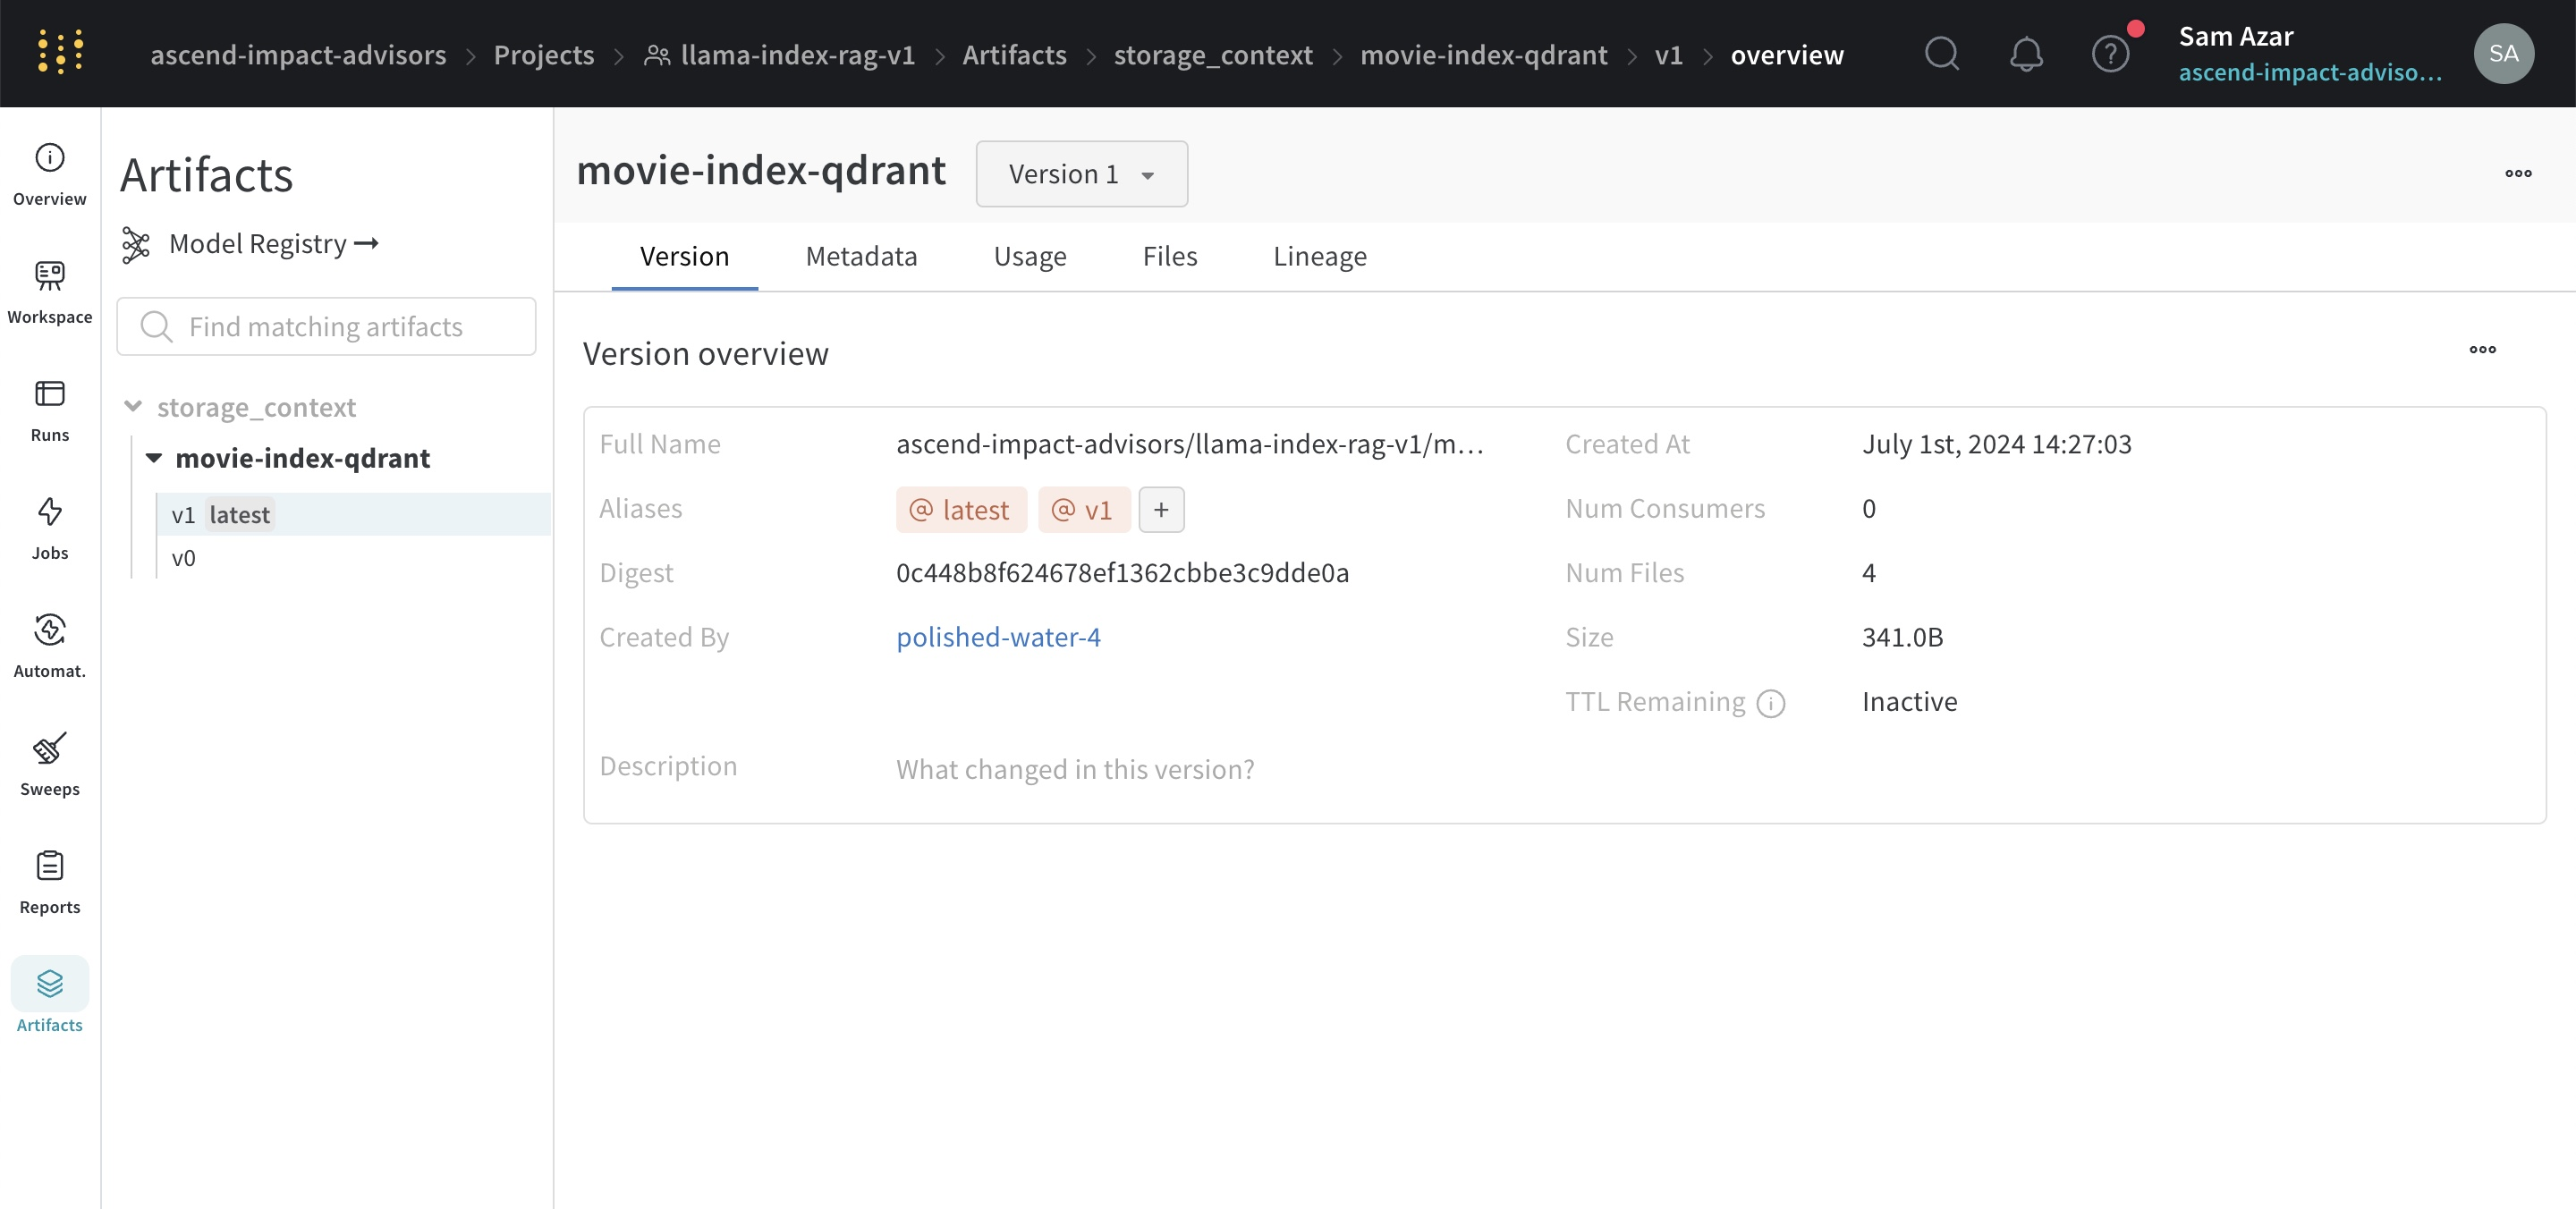

In [90]:
from IPython.display import Image, display

image_path = '/Users/sampazar/ML-Ops/AIE3/Week 5/Day 1/wandb_screenshot.jpeg'

display(Image(filename='/Users/sampazar/ML-Ops/AIE3/Week 5/Day 1/wandb_screenshot.jpeg'))

## Task 5: Simple RAG - QueryEngine

Now that we're created our `VectorStoreIndex`, powered by a QDrant VectorStore, we can wrap it in a simple `QueryEngine` using the `as_query_engine()` method - which will connect a few things together for us:

In [91]:
simple_rag = index.as_query_engine()

Before we test this out - let's see what information we can find out about from our new `QueryEngine`!

In [92]:
for k, v in simple_rag.get_prompts().items():
  print(v.get_template())
  print("\n~~~~~~~~~~~~~~~~~~\n")

Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer: 

~~~~~~~~~~~~~~~~~~

The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Refined Answer: 

~~~~~~~~~~~~~~~~~~



Let's see how it does!

In [93]:
response = simple_rag.query("Who is the evil Wizard in the story?")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


wandb: Logged trace tree to W&B.


In [94]:
response.response

'The evil wizard in the story is Saruman the White.'

That makes sense!

Let's ask a question that's slightly more...ambiguous.

In [95]:
response = simple_rag.query("Who are the giant beings that roam across the world?")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


wandb: Logged trace tree to W&B.


In [96]:
response.response

'The giant beings that roam across the world are the sandworms.'

We can check the source nodes to see which movies we retrieved.

In [97]:
print([x.metadata["title"] for x in response.source_nodes])

['Dune (2021 film)', 'The Lord of the Rings: The Fellowship of the Ring']


Okay, so in this case - we've gone with "Sandworms " from Dune.

But there's also the Ents from Lord of the Rings, and it looks like we got documents from Lord of the Rings as well.

Let's see if there's a way we can use the title metadata we added to filter the results we get!

## Task 6: Auto Retriever Functional Tool

This tool will leverage OpenAI's functional endpoint to select the correct metadata filter and query the filtered index - only looking at nodes with the desired metadata.

A simplified diagram: ![image](https://i.imgur.com/AICDPav.png)

First, we need to create our `VectoreStoreInfo` object which will hold all the relevant metadata we need for each component (in this case title metadata).

Notice that you need to include it in a text list.

In [98]:
from llama_index.core.tools import FunctionTool
from llama_index.core.vector_stores.types import (
    VectorStoreInfo,
    MetadataInfo,
    ExactMatchFilter,
    MetadataFilters,
)
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine

from typing import List, Tuple, Any
from pydantic import BaseModel, Field

top_k = 3

vector_store_info = VectorStoreInfo(
    content_info="semantic information about movies",
    metadata_info=[MetadataInfo(
        name="title",
        type="str",
        description='title of the movie, one of ["Dune (2021 film)", "Dune: Part Two", "The Lord of the Rings: The Fellowship of the Ring", "The Lord of the Rings: The Two Towers"]'
        )]
)

Now we'll create our base PyDantic object that we can use to ensure compatability with our application layer. This verifies that the response from the OpenAI endpoint conforms to this schema.

In [99]:
class AutoRetrieveModel(BaseModel):
    query: str = Field(..., description="natural language query string")
    filter_key_list: List[str] = Field(
        ..., description="List of metadata filter field names"
    )
    filter_value_list: List[str] = Field(
        ...,
        description=(
            "List of metadata filter field values (corresponding to names specified in filter_key_list)"
        )
    )

Now we can build our function that we will use to query the functional endpoint.

In [100]:
def auto_retrieve_fn(
    query: str, filter_key_list: List[str], filter_value_list: List[str]
):
    """Auto retrieval function.

    Performs auto-retrieval from a vector database, and then applies a set of filters.

    """
    query = query or "Query"

    exact_match_filters = [
        ExactMatchFilter(key=k, value=v)
        for k, v in zip(filter_key_list, filter_value_list)
    ]
    retriever = VectorIndexRetriever(
        index, filters=MetadataFilters(filters=exact_match_filters), top_k=top_k
    )
    query_engine = RetrieverQueryEngine.from_args(retriever)

    response = query_engine.query(query)
    return str(response)

Now we need to wrap our system in a tool in order to integrate it into the larger application.

Source Code Here:
- [`FunctionTool`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/tools/function_tool.py#L21)

In [101]:
description = f"""\
Use this tool to look up non-review based information about films.
The vector database schema is given below:
{vector_store_info.json()}
"""

auto_retrieve_tool = FunctionTool.from_defaults(
    fn=auto_retrieve_fn,
    name="semantic-film-info",
    description=description,
    fn_schema=AutoRetrieveModel
)

####❓ Question #3:

Is the text in the description of our `FunctionTool` important or not? Please explain your answer.

Yes, it's important. Without that description, the system wouldn't know when or why to call that function.

All that's left to do is attach the tool to an OpenAIAgent and let it rip!

Source Code Here:
- [`OpenAIAgent`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/agent/openai_agent.py#L361)

In [102]:
from llama_index.core.agent import FunctionCallingAgentWorker

agent_worker = FunctionCallingAgentWorker.from_tools(
    tools=[auto_retrieve_tool],
    verbose=True,
)

agent = agent_worker.as_agent()

In [103]:
response = agent.chat("Who starred in the 2021 film?")

Added user message to memory: Who starred in the 2021 film?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "Who starred in the 2021 film?", "filter_key_list": ["title"], "filter_value_list": ["Dune (2021 film)"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Function Out

wandb: Logged trace tree to W&B.


=== LLM Response ===
The 2021 film "Dune" featured a star-studded cast, including:

- Timothée Chalamet as Paul
- Rebecca Ferguson as Lady Jessica
- Dave Bautista as Glossu Rabban
- Stellan Skarsgård as Baron Vladimir Harkonnen
- Charlotte Rampling as Gaius Helen Mohiam
- Oscar Isaac as Duke Leto
- Zendaya as Chani
- Javier Bardem as Stilgar
- Josh Brolin as Gurney Halleck
- Jason Momoa as Duncan Idaho
- David Dastmalchian as Piter de Vries
- Stephen McKinley Henderson
- Chang Chen as Dr. Yueh
- Benjamin Clementine as the Herald of the Change


In [104]:
response = agent.chat("Who are the giant beings that roam across the world in the movies?")

Added user message to memory: Who are the giant beings that roam across the world in the movies?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "giant beings that roam across the world", "filter_key_list": ["title"], "filter_value_list": ["Dune (2021 film)"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat

wandb: Logged trace tree to W&B.


=== LLM Response ===
In the movies:

- **Dune (2021 film)**: The giant beings that roam across the world are the sandworms. They travel under the desert and pose a significant danger during spice harvesting.

- **The Lord of the Rings: The Two Towers**: The giant beings are the Ents, led by Treebeard. They are ancient tree-like creatures who play a significant role in the story, particularly in their decision to go to war against Saruman after witnessing the destruction he has caused to the forest.

- **The Lord of the Rings: The Fellowship of the Ring**: There is no specific mention of giant beings that roam across the world in this context.


# 🤝 Breakout Room #2

## Quantitative RAG Pipeline with NL2SQL Tooling

We'll walk through the steps of creating a natural language to SQL system in the following section.

> NOTICE: This does not have parsing on the inputs or intermediary calls to ensure that users are using safe SQL queries. Use this with caution in a production environment without adding specific guardrails from either side of the application.

The next few steps should be largely straightforward, we'll want to:

1. Read in our `.csv` files into `pd.DataFrame` objects
2. Create an in-memory `sqlite` powered `sqlalchemy` engine
3. Cast our `pd.DataFrame` objects to the SQL engine
4. Create an `SQLDatabase` object through LlamaIndex
5. Use that to create a `QueryEngineTool` that we can interact with through the `NLSQLTableQueryEngine`!

If you get stuck, please consult the documentation.

In [105]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune1.csv

10325.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
--2024-07-01 14:57:42--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133391 (130K) [text/plain]
Saving to: ‘dune1.csv’

dune1.csv           100%[===================>] 130.26K  --.-KB/s    in 0.02s   

2024-07-01 14:57:42 (8.42 MB/s) - ‘dune1.csv’ saved [133391/133391]



In [106]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune2.csv

10335.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
--2024-07-01 14:57:51--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111843 (109K) [text/plain]
Saving to: ‘dune2.csv’

dune2.csv           100%[===================>] 109.22K  --.-KB/s    in 0.01s   

2024-07-01 14:57:51 (8.69 MB/s) - ‘dune2.csv’ saved [111843/111843]



In [107]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/lotr_fotr.csv

10342.59s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
--2024-07-01 14:57:59--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/lotr_fotr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172855 (169K) [text/plain]
Saving to: ‘lotr_fotr.csv’

lotr_fotr.csv       100%[===================>] 168.80K  --.-KB/s    in 0.02s   

2024-07-01 14:57:59 (9.00 MB/s) - ‘lotr_fotr.csv’ saved [172855/172855]



In [108]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/lotr_tt.csv

10349.87s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
--2024-07-01 14:58:06--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/lotr_tt.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114598 (112K) [text/plain]
Saving to: ‘lotr_tt.csv’

lotr_tt.csv         100%[===================>] 111.91K  --.-KB/s    in 0.008s  

2024-07-01 14:58:06 (14.0 MB/s) - ‘lotr_tt.csv’ saved [114598/114598]



#### Read `.csv` Into Pandas

In [109]:
import pandas as pd

dune1 = pd.read_csv("./dune1.csv")
dune2 = pd.read_csv("./dune2.csv")
lotr_fotr = pd.read_csv("./lotr_fotr.csv")
lotr_tt = pd.read_csv("./lotr_tt.csv")

#### Create SQLAlchemy engine with SQLite

In [110]:
from sqlalchemy import create_engine

engine = create_engine("sqlite+pysqlite:///:memory:")

#### Convert `pd.DataFrame` to SQL tables

In [111]:
dune1.to_sql(
  "Dune (2021 film)",
  engine
)

274

In [112]:
dune2.to_sql(
  "Dune: Part Two",
  engine
)

175

In [113]:
lotr_fotr.to_sql(
  "The Lord of the Rings: The Fellowship of the Ring",
  engine
)

250

In [114]:
lotr_tt.to_sql(
  "The Lord of the Rings: The Two Towers",
  engine
)

149

#### Construct a `SQLDatabase` index

Source Code Here:
- [`SQLDatabase`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/langchain_helpers/sql_wrapper.py#L9)

In [115]:
from llama_index.core import SQLDatabase

sql_database = SQLDatabase(
    engine=engine,
    include_tables=movie_list
)

#### Create the NLSQLTableQueryEngine interface for all added SQL tables

Source Code Here:
- [`NLSQLTableQueryEngine`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/indices/struct_store/sql_query.py#L75C1-L75C1)

In [116]:
from llama_index.core.indices.struct_store.sql_query import NLSQLTableQueryEngine

sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=movie_list,
)

#### Wrap It All Up in a `QueryEngineTool`

You'll want to ensure you have a descriptive...description!

This is what will help the LLM decide which table to use when querying!

Sorce Code Here:

- [`QueryEngineTool`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/tools/query_engine.py#L13)

####🏗️ Activity #1:

Please write a Natural Language Description for the tables that we are using today.

Here is an example:

```
This tool should be used to answer any and all review related inquiries by translating a natural language query into a SQL query with access to tables:
'Dune (2021 film)' - containing info. about the first movie in the Dune series,
'Dune: Part Two'- containing info. about about the second movie in the Dune series,
'The Lord of the Rings: The Fellowship of the Ring' - containing info. about the first movie in the Lord of the Ring series,
'The Lord of the Rings: The Two Towers' - containing info. the second movie in the Lord of the Ring series,
```

In [117]:
DESCRIPTION = """
This tool should be used to answer any and all review related inquiries by translating a natural language query into a SQL query with access to tables:
'Dune (2021 film)' - Includes reviews about the first movie in the Dune series including Review Date, Review Author, Rating, Review Title, Review, and a link to the review,
'Dune: Part Two'- Includes reviews about the second movie in the Dune series including Review Date, Review Author, Rating, Review Title, Review, and a link to the review,
'The Lord of the Rings: The Fellowship of the Ring' - Includes reviews about the first movie in the Lord of the Ring series including Review Date, Review Author, Rating, Review Title, Review, and a link to the review,
'The Lord of the Rings: The Two Towers' - Includes reviews about the second movie in the Lord of the Ring series including Review Date, Review Author, Rating, Review Title, Review, and a link to the review,

"""

In [118]:
from llama_index.core.tools.query_engine import QueryEngineTool

sql_tool = QueryEngineTool.from_defaults(
    query_engine=sql_query_engine,
    name="sql-query",
    description=DESCRIPTION,
)

In [119]:
agent_worker = FunctionCallingAgentWorker.from_tools(
    tools=[sql_tool],
    verbose=True
)

agent = agent_worker.as_agent()

In [120]:
response = agent.chat("What is the average rating of the 2nd Lord of the Rings movie?")

Added user message to memory: What is the average rating of the 2nd Lord of the Rings movie?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: sql-query with args: {"input": "SELECT AVG(Rating) as Average_Rating FROM \"The Lord of the Rings: The Two Towers\""}
INFO:llama_index.core.indices.struct_store.sql_retriever:> Table desc str: Table 'Dune (2021 film)' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .

Table 'Dune: Part Two' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .

Table 'The Lord of

wandb: Logged trace tree to W&B.


=== LLM Response ===
The average rating for "The Lord of the Rings: The Two Towers" is approximately 9.18.


In [121]:
print(str(response))

The average rating for "The Lord of the Rings: The Two Towers" is approximately 9.18.


In [122]:
response = agent.chat("What movie series has better reviews, Lord of the Rings or Dune?")

Added user message to memory: What movie series has better reviews, Lord of the Rings or Dune?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: sql-query with args: {"input": "SELECT AVG(Rating) as Average_Rating FROM \"Dune (2021 film)\""}
INFO:llama_index.core.indices.struct_store.sql_retriever:> Table desc str: Table 'Dune (2021 film)' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .

Table 'Dune: Part Two' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .

Table 'The Lord of the Rings: The Fel

wandb: Logged trace tree to W&B.


=== LLM Response ===
Here are the average ratings for the movies in each series:

**Dune Series:**
- **Dune (2021):** 8.34
- **Dune: Part Two:** 8.71

**Lord of the Rings Series:**
- **The Fellowship of the Ring:** 9.87
- **The Two Towers:** 9.18

Based on these average ratings, the **Lord of the Rings** series has better reviews compared to the **Dune** series.


In [123]:
print(str(response))

Here are the average ratings for the movies in each series:

**Dune Series:**
- **Dune (2021):** 8.34
- **Dune: Part Two:** 8.71

**Lord of the Rings Series:**
- **The Fellowship of the Ring:** 9.87
- **The Two Towers:** 9.18

Based on these average ratings, the **Lord of the Rings** series has better reviews compared to the **Dune** series.


### Task 2: Combined RAG Pipeline

Now, we can simply add our tools into the `OpenAIAgent`, and off we go!

In [124]:
combined_tool_agent_worker = FunctionCallingAgentWorker.from_tools(
    tools=[auto_retrieve_tool, sql_tool],
    verbose=True
)

combined_tool_agent = combined_tool_agent_worker.as_agent()

In [125]:
response = combined_tool_agent.chat("Which movie is about a ring, and what is the average rating of the movie?")

Added user message to memory: Which movie is about a ring, and what is the average rating of the movie?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "movie about a ring", "filter_key_list": ["title"], "filter_value_list": ["The Lord of the Rings: The Fellowship of the Ring", "The Lord of the Rings: The Two Towers"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1

wandb: Logged trace tree to W&B.


=== LLM Response ===
The movie about a ring is **"The Lord of the Rings: The Fellowship of the Ring"**. It tells the story of the Dark Lord Sauron, who seeks the One Ring to return to power. The Ring has found its way to the young hobbit Frodo Baggins, and the fate of Middle-earth hangs in the balance as Frodo and eight companions (the Fellowship of the Ring) embark on a perilous journey to Mount Doom in Mordor, the only place where the Ring can be destroyed.

The average rating for **"The Lord of the Rings: The Fellowship of the Ring"** is approximately **9.87**.


In [126]:
print(str(response))

The movie about a ring is **"The Lord of the Rings: The Fellowship of the Ring"**. It tells the story of the Dark Lord Sauron, who seeks the One Ring to return to power. The Ring has found its way to the young hobbit Frodo Baggins, and the fate of Middle-earth hangs in the balance as Frodo and eight companions (the Fellowship of the Ring) embark on a perilous journey to Mount Doom in Mordor, the only place where the Ring can be destroyed.

The average rating for **"The Lord of the Rings: The Fellowship of the Ring"** is approximately **9.87**.


In [127]:
response = combined_tool_agent.chat("What worlds do the LoTR, and Dune movies take place in?")

Added user message to memory: What worlds do the LoTR, and Dune movies take place in?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "world where the movie takes place", "filter_key_list": ["title"], "filter_value_list": ["The Lord of the Rings: The Fellowship of the Ring", "The Lord of the Rings: The Two Towers"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 

wandb: Logged trace tree to W&B.


=== LLM Response ===
The **"The Lord of the Rings"** movies take place in the fictional world of **Middle-earth**.

The **"Dune"** movies take place in a distant future where humanity has spread across the universe and settled on various planets. Key locations include:
- **Arrakis**: The desert planet known for its valuable spice melange.
- **Caladan**: The oceanic home planet of House Atreides.
- **Giedi Prime**: The industrial home of House Harkonnen.

The world of Dune is characterized by its complex political, social, and ecological systems, with significant emphasis on the struggle for control over Arrakis and its spice.


In [128]:
print(str(response))

The **"The Lord of the Rings"** movies take place in the fictional world of **Middle-earth**.

The **"Dune"** movies take place in a distant future where humanity has spread across the universe and settled on various planets. Key locations include:
- **Arrakis**: The desert planet known for its valuable spice melange.
- **Caladan**: The oceanic home planet of House Atreides.
- **Giedi Prime**: The industrial home of House Harkonnen.

The world of Dune is characterized by its complex political, social, and ecological systems, with significant emphasis on the struggle for control over Arrakis and its spice.


In [129]:
response = combined_tool_agent.chat("Which of the following movie series is considered the 'best': Dune, or Lord of the Rings? Base your answer on both reviews, and non-review information.")

Added user message to memory: Which of the following movie series is considered the 'best': Dune, or Lord of the Rings? Base your answer on both reviews, and non-review information.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: sql-query with args: {"input": "SELECT AVG(Rating) as AverageRating FROM 'Dune (2021 film)'"}
INFO:llama_index.core.indices.struct_store.sql_retriever:> Table desc str: Table 'Dune (2021 film)' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .

Table 'Dune: Part Two' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (

wandb: Logged trace tree to W&B.


=== LLM Response ===
Based on the average ratings from reviews:

- **"The Lord of the Rings: The Fellowship of the Ring"** has an average rating of approximately **9.87**.
- **"The Lord of the Rings: The Two Towers"** has an average rating of approximately **9.18**.
- **"Dune (2021 film)"** has an average rating of approximately **8.34**.
- **"Dune: Part Two"** has an average rating of approximately **8.71**.

From the review perspective, the **"Lord of the Rings"** series has higher average ratings compared to the **"Dune"** series.

However, based on non-review information, both series are highly regarded for their complex worlds and storytelling. "The Lord of the Rings" is set in the richly detailed world of Middle-earth, while "Dune" is set in a distant future with intricate political, social, and ecological systems.

Considering both reviews and non-review information, the **"Lord of the Rings"** series is generally considered the best based on higher average ratings.


In [130]:
print(str(response))

Based on the average ratings from reviews:

- **"The Lord of the Rings: The Fellowship of the Ring"** has an average rating of approximately **9.87**.
- **"The Lord of the Rings: The Two Towers"** has an average rating of approximately **9.18**.
- **"Dune (2021 film)"** has an average rating of approximately **8.34**.
- **"Dune: Part Two"** has an average rating of approximately **8.71**.

From the review perspective, the **"Lord of the Rings"** series has higher average ratings compared to the **"Dune"** series.

However, based on non-review information, both series are highly regarded for their complex worlds and storytelling. "The Lord of the Rings" is set in the richly detailed world of Middle-earth, while "Dune" is set in a distant future with intricate political, social, and ecological systems.

Considering both reviews and non-review information, the **"Lord of the Rings"** series is generally considered the best based on higher average ratings.


####❓ Question #4:

How can you verify which tool was used for which query?

It's listed under "calling function" after "FROM" within the "response".

In [131]:
wandb_callback.finish()